This script processes the data for use in the ml models.  This includes imputing missing values and feature engineering.

In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import date, datetime, timedelta
from collections import defaultdict
import seaborn as sns

In [26]:
#select format type for data. 'concat' or 'team_difference'
format_type = 'team_difference'

In [2]:
start_time = datetime.now()

#pull in boxscore data
con = sqlite3.connect('nba.db')

team_basic_boxscores_df = pd.read_sql('select * from team_basic_boxscores', con)
team_advanced_boxscores_df = pd.read_sql('select * from team_advanced_boxscores', con)

team_boxscores_df = team_basic_boxscores_df.merge(team_advanced_boxscores_df, how='inner', on=['GAME_ID', 'TEAM_ID'])

pd.set_option('display.max_columns', None)
team_boxscores_df.head()

,SEASON,TEAM_ID,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE,MATCHUP,WL,MIN_x,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_NAME_y,TEAM_ABBREVIATION_y,TEAM_CITY,MIN_y,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE
0,2021-22,1610612747,LAL,Los Angeles Lakers,0022100002,2021-10-19,LAL vs. GSW,L,240,45,95,0.474,15,42,0.357,9,19,0.474,5,40,45,21,7,4,18,25,114,-7,Lakers,LAL,Los Angeles,240:00,98.0,101.8,106.0,107.1,-8.0,-5.3,0.467,1.17,14.8,0.189,0.759,0.477,15.469,16.1,0.553,0.551,1.0,0.198,115.28,112.5,93.75,112.0,0.422
1,2021-22,1610612744,GSW,Golden State Warriors,0022100002,2021-10-19,GSW @ LAL,W,240,41,93,0.441,14,39,0.359,25,30,0.833,9,41,50,30,9,2,17,18,121,7,Warriors,GSW,Golden State,240:00,106.0,107.1,98.0,101.8,8.0,5.3,0.732,1.76,19.6,0.241,0.811,0.523,14.886,15.0,0.516,0.570,1.0,0.200,115.28,112.5,93.75,113.0,0.578
2,2021-22,1610612751,BKN,Brooklyn Nets,0022100001,2021-10-19,BKN @ MIL,L,240,37,84,0.440,17,32,0.531,13,23,0.565,5,39,44,19,3,9,13,17,104,-23,Nets,BKN,Brooklyn,240:00,101.8,102.0,117.7,124.5,-15.8,-22.5,0.514,1.46,15.1,0.176,0.707,0.459,12.730,12.7,0.542,0.552,1.0,0.200,105.02,102.0,85.00,102.0,0.407
3,2021-22,1610612749,MIL,Milwaukee Bucks,0022100001,2021-10-19,MIL vs. BKN,W,240,48,105,0.457,17,45,0.378,14,18,0.778,13,41,54,25,8,9,8,19,127,23,Bucks,MIL,Milwaukee,240:00,117.7,124.5,101.8,102.0,15.8,22.5,0.521,3.13,17.1,0.293,0.824,0.541,7.413,7.8,0.538,0.562,1.0,0.194,105.02,102.0,85.00,102.0,0.593
4,2021-22,1610612754,IND,Indiana Pacers,0022100003,2021-10-20,IND @ CHA,L,240,42,90,0.467,17,47,0.362,21,24,0.875,8,43,51,29,2,10,17,24,122,-1,Pacers,IND,Indiana,240:00,111.4,114.0,107.1,116.0,4.3,-2.0,0.690,1.71,19.8,0.255,0.667,0.487,15.517,15.9,0.561,0.607,1.0,0.199,112.22,106.5,88.75,107.0,0.520


In [3]:
#add home team flag
team_boxscores_df['HOME_TEAM'] = team_boxscores_df['MATCHUP'].str[4] == 'v'

team_boxscores_df['HOME_TEAM']

0         True
1        False
2        False
3         True
4        False
         ...  
56303     True
56304     True
56305    False
56306    False
56307     True
Name: HOME_TEAM, Length: 56308, dtype: bool

In [4]:
team_boxscores_df.columns

Index(['SEASON', 'TEAM_ID', 'TEAM_ABBREVIATION_x', 'TEAM_NAME_x', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN_x', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'TEAM_NAME_y',
       'TEAM_ABBREVIATION_y', 'TEAM_CITY', 'MIN_y', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'HOME_TEAM'],
      dtype='object')

In [5]:
team_boxscores_df.drop(columns=['TEAM_ABBREVIATION_x',
                                'TEAM_NAME_x',
                                'MATCHUP',
                                'TEAM_NAME_y',
                                'TEAM_ABBREVIATION_y',
                                'MIN_y'], inplace=True)
team_boxscores_df.rename(columns={'MIN_x':'MIN'}, inplace=True)
team_boxscores_df.head()

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM
0,2021-22,1610612747,0022100002,2021-10-19,L,240,45,95,0.474,15,42,0.357,9,19,0.474,5,40,45,21,7,4,18,25,114,-7,Los Angeles,98.0,101.8,106.0,107.1,-8.0,-5.3,0.467,1.17,14.8,0.189,0.759,0.477,15.469,16.1,0.553,0.551,1.0,0.198,115.28,112.5,93.75,112.0,0.422,True
1,2021-22,1610612744,0022100002,2021-10-19,W,240,41,93,0.441,14,39,0.359,25,30,0.833,9,41,50,30,9,2,17,18,121,7,Golden State,106.0,107.1,98.0,101.8,8.0,5.3,0.732,1.76,19.6,0.241,0.811,0.523,14.886,15.0,0.516,0.570,1.0,0.200,115.28,112.5,93.75,113.0,0.578,False
2,2021-22,1610612751,0022100001,2021-10-19,L,240,37,84,0.440,17,32,0.531,13,23,0.565,5,39,44,19,3,9,13,17,104,-23,Brooklyn,101.8,102.0,117.7,124.5,-15.8,-22.5,0.514,1.46,15.1,0.176,0.707,0.459,12.730,12.7,0.542,0.552,1.0,0.200,105.02,102.0,85.00,102.0,0.407,False
3,2021-22,1610612749,0022100001,2021-10-19,W,240,48,105,0.457,17,45,0.378,14,18,0.778,13,41,54,25,8,9,8,19,127,23,Milwaukee,117.7,124.5,101.8,102.0,15.8,22.5,0.521,3.13,17.1,0.293,0.824,0.541,7.413,7.8,0.538,0.562,1.0,0.194,105.02,102.0,85.00,102.0,0.593,True
4,2021-22,1610612754,0022100003,2021-10-20,L,240,42,90,0.467,17,47,0.362,21,24,0.875,8,43,51,29,2,10,17,24,122,-1,Indiana,111.4,114.0,107.1,116.0,4.3,-2.0,0.690,1.71,19.8,0.255,0.667,0.487,15.517,15.9,0.561,0.607,1.0,0.199,112.22,106.5,88.75,107.0,0.520,False


In [6]:
#check for misssing values
team_boxscores_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56308 entries, 0 to 56307
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        56308 non-null  object 
 1   TEAM_ID       56308 non-null  int64  
 2   GAME_ID       56308 non-null  object 
 3   GAME_DATE     56308 non-null  object 
 4   WL            56308 non-null  object 
 5   MIN           56308 non-null  int64  
 6   FGM           56308 non-null  int64  
 7   FGA           56308 non-null  int64  
 8   FG_PCT        56308 non-null  float64
 9   FG3M          56308 non-null  int64  
 10  FG3A          56308 non-null  int64  
 11  FG3_PCT       56308 non-null  float64
 12  FTM           56308 non-null  int64  
 13  FTA           56308 non-null  int64  
 14  FT_PCT        56308 non-null  float64
 15  OREB          56308 non-null  int64  
 16  DREB          56308 non-null  int64  
 17  REB           56308 non-null  int64  
 18  AST           56308 non-nu

In [7]:
#manually calculate estimation of missing rebound percentage stats
oreb_pct_calc = np.empty(len(team_boxscores_df))
dreb_pct_calc = np.empty(len(team_boxscores_df))
reb_pct_calc = np.empty(len(team_boxscores_df))

for i, row in tqdm(team_boxscores_df.iterrows()):
    game_id = row['GAME_ID']
    team_id = row['TEAM_ID']
    
    opp_row = team_boxscores_df[team_boxscores_df['GAME_ID'] == game_id]
    opp_row = opp_row[opp_row['TEAM_ID'] != team_id]
    
    oreb_pct_calc[i] = row['OREB'] / (row['OREB'] + opp_row['DREB'])
    dreb_pct_calc[i] = row['DREB'] / (row['DREB'] + opp_row['OREB'])
    reb_pct_calc[i] = row['REB'] / (row['REB'] + opp_row['REB'])

team_boxscores_df['OREB_PCT_CALC'] = oreb_pct_calc
team_boxscores_df['DREB_PCT_CALC'] = dreb_pct_calc
team_boxscores_df['REB_PCT_CALC'] = reb_pct_calc


#calculate error of calculated stats
team_boxscores_df['OREB_PCT_CALC_DIFF'] = team_boxscores_df['OREB_PCT'] - team_boxscores_df['OREB_PCT_CALC']
team_boxscores_df['DREB_PCT_CALC_DIFF'] = team_boxscores_df['DREB_PCT'] - team_boxscores_df['DREB_PCT_CALC']
team_boxscores_df['REB_PCT_CALC_DIFF'] = team_boxscores_df['REB_PCT'] - team_boxscores_df['REB_PCT_CALC']



56308it [07:00, 134.03it/s]


Text(0, 0.5, 'count')

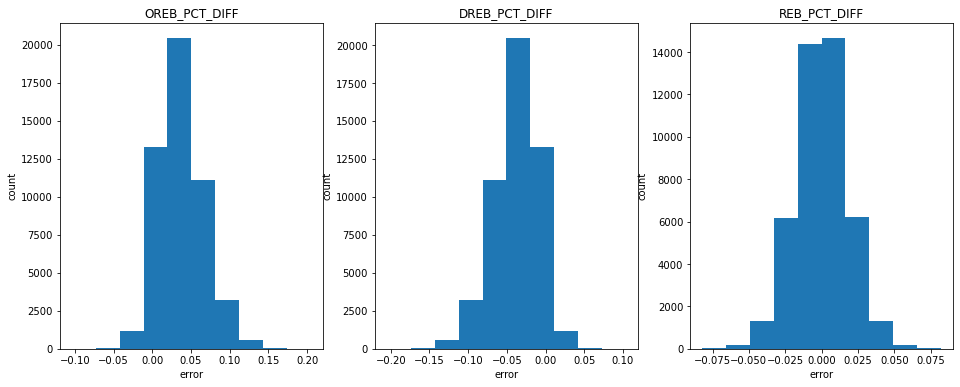

In [8]:
#plot error of calculated rebound percentage stats
fig, axes = plt.subplots(1, 3, figsize=[16, 6])

axes[0].hist(team_boxscores_df['OREB_PCT_CALC_DIFF'])
axes[0].set_title('OREB_PCT_DIFF')
axes[0].set_xlabel('error')
axes[0].set_ylabel('count')

axes[1].hist(team_boxscores_df['DREB_PCT_CALC_DIFF'])
axes[1].set_title('DREB_PCT_DIFF')
axes[1].set_xlabel('error')
axes[1].set_ylabel('count')

axes[2].hist(team_boxscores_df['REB_PCT_CALC_DIFF'])
axes[2].set_title('REB_PCT_DIFF')
axes[2].set_xlabel('error')
axes[2].set_ylabel('count')


In [9]:
#fill in missing rebound percentage stats with calculated values
rebound_pct_cols = ['OREB_PCT', 'DREB_PCT', 'REB_PCT']

for col in rebound_pct_cols:
    team_boxscores_df[col].fillna(value=team_boxscores_df[col + '_CALC'], inplace=True)

team_boxscores_df.drop(columns=['OREB_PCT_CALC_DIFF',
                                'DREB_PCT_CALC_DIFF',
                                'REB_PCT_CALC_DIFF',
                                'OREB_PCT_CALC',
                                'DREB_PCT_CALC',
                                'REB_PCT_CALC'], inplace=True)
team_boxscores_df.head()

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM
0,2021-22,1610612747,0022100002,2021-10-19,L,240,45,95,0.474,15,42,0.357,9,19,0.474,5,40,45,21,7,4,18,25,114,-7,Los Angeles,98.0,101.8,106.0,107.1,-8.0,-5.3,0.467,1.17,14.8,0.189,0.759,0.477,15.469,16.1,0.553,0.551,1.0,0.198,115.28,112.5,93.75,112.0,0.422,True
1,2021-22,1610612744,0022100002,2021-10-19,W,240,41,93,0.441,14,39,0.359,25,30,0.833,9,41,50,30,9,2,17,18,121,7,Golden State,106.0,107.1,98.0,101.8,8.0,5.3,0.732,1.76,19.6,0.241,0.811,0.523,14.886,15.0,0.516,0.570,1.0,0.200,115.28,112.5,93.75,113.0,0.578,False
2,2021-22,1610612751,0022100001,2021-10-19,L,240,37,84,0.440,17,32,0.531,13,23,0.565,5,39,44,19,3,9,13,17,104,-23,Brooklyn,101.8,102.0,117.7,124.5,-15.8,-22.5,0.514,1.46,15.1,0.176,0.707,0.459,12.730,12.7,0.542,0.552,1.0,0.200,105.02,102.0,85.00,102.0,0.407,False
3,2021-22,1610612749,0022100001,2021-10-19,W,240,48,105,0.457,17,45,0.378,14,18,0.778,13,41,54,25,8,9,8,19,127,23,Milwaukee,117.7,124.5,101.8,102.0,15.8,22.5,0.521,3.13,17.1,0.293,0.824,0.541,7.413,7.8,0.538,0.562,1.0,0.194,105.02,102.0,85.00,102.0,0.593,True
4,2021-22,1610612754,0022100003,2021-10-20,L,240,42,90,0.467,17,47,0.362,21,24,0.875,8,43,51,29,2,10,17,24,122,-1,Indiana,111.4,114.0,107.1,116.0,4.3,-2.0,0.690,1.71,19.8,0.255,0.667,0.487,15.517,15.9,0.561,0.607,1.0,0.199,112.22,106.5,88.75,107.0,0.520,False


In [10]:
team_boxscores_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56308 entries, 0 to 56307
Data columns (total 50 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        56308 non-null  object 
 1   TEAM_ID       56308 non-null  int64  
 2   GAME_ID       56308 non-null  object 
 3   GAME_DATE     56308 non-null  object 
 4   WL            56308 non-null  object 
 5   MIN           56308 non-null  int64  
 6   FGM           56308 non-null  int64  
 7   FGA           56308 non-null  int64  
 8   FG_PCT        56308 non-null  float64
 9   FG3M          56308 non-null  int64  
 10  FG3A          56308 non-null  int64  
 11  FG3_PCT       56308 non-null  float64
 12  FTM           56308 non-null  int64  
 13  FTA           56308 non-null  int64  
 14  FT_PCT        56308 non-null  float64
 15  OREB          56308 non-null  int64  
 16  DREB          56308 non-null  int64  
 17  REB           56308 non-null  int64  
 18  AST           56308 non-nu

In [11]:
#store actual point spread for each game
game_ids = team_boxscores_df['GAME_ID'].unique()
spreads = np.empty(len(game_ids))

for i, game_id in tqdm(enumerate(game_ids)):
    spread = team_boxscores_df[(team_boxscores_df['GAME_ID']==game_id) &
                               (team_boxscores_df['HOME_TEAM']==True)]['PLUS_MINUS']
    spreads[i] = spread

game_spreads_df = pd.DataFrame(data={'GAME_ID':game_ids, 'SPREAD':spreads})
game_spreads_df.head()

28154it [02:58, 157.30it/s]


,GAME_ID,SPREAD
0,0022100002,-7.0
1,0022100001,23.0
2,0022100003,1.0
3,0022100004,-6.0
4,0022100006,-15.0


In [12]:
#change W/L column to 1's and 0's
team_boxscores_df['WL'] = team_boxscores_df['WL'].map({'W':1, 'L':0})

#convert game date to datetime
team_boxscores_df['GAME_DATE'] = pd.to_datetime(team_boxscores_df['GAME_DATE'])


In [13]:
#elo rating helper functions
#credit to rogerfitz

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team

def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    team_rating += 100
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
            
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)

    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    

def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating


In [14]:
def add_elo_ratings(df):
    df.sort_values(['GAME_DATE', 'GAME_ID', 'HOME_TEAM'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    elo_col = np.empty(df.shape[0])
    elo_dict = {}
    cur_season = df.iloc[0]['SEASON']
    
    for i, row in tqdm(df.iterrows()):
        
        if i%2 != 0:
            continue
        
        if row['SEASON'] != cur_season:
            cur_season = row['SEASON']
            elo_dict = {team_id:season_reset(elo) for team_id, elo in elo_dict.items()}
        
        away_row = row
        home_row = df.iloc[i+1]
        
        #check both rows are from same game
        if away_row['GAME_ID'] != home_row['GAME_ID']:
            print('game ids do not match')
            print('home game id: ', home_row['GAME_ID'])
            print('away game id: ', away_row['GAME_ID'])
            print('iteration: ', i)
            break
        
        home_team_id = home_row['TEAM_ID']
        away_team_id = away_row['TEAM_ID']
        
        if home_team_id not in elo_dict:
            elo_dict[home_team_id] = 1300
        if away_team_id not in elo_dict:
            elo_dict[away_team_id] = 1300
        
        home_elo = elo_dict[home_team_id]
        away_elo = elo_dict[away_team_id]

        elo_col[i+1] = home_elo
        elo_col[i] = away_elo
        
        home_pts = home_row['PTS']
        away_pts = away_row['PTS']

        home_elo_update, away_elo_update = elo_update(home_pts, away_pts, home_elo, away_elo)
        
        new_home_elo = home_elo + home_elo_update
        new_away_elo = away_elo + away_elo_update
        
        elo_dict[home_team_id] = new_home_elo
        elo_dict[away_team_id] = new_away_elo
    
    df['ELO'] = elo_col
        
    return df
        
    

In [15]:
#add elo ratings
team_boxscores_df = add_elo_ratings(team_boxscores_df)
team_boxscores_df.head()

56308it [00:09, 5747.59it/s]


,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM,ELO
0,2000-01,1610612755,0020000001,2000-10-31,1,240,38,66,0.576,3,8,0.375,22,30,0.733,8,29,37,27,10,5,14,24,101,29,Philadelphia,118.5,114.8,81.3,81.8,37.2,33.0,0.711,1.93,22.5,0.258065,0.646000,0.500,16.432,15.9,0.598,0.638,1.0,0.200,86.88,88.0,73.33,88.0,0.819,False,1300.0
1,2000-01,1610612752,0020000001,2000-10-31,0,240,25,70,0.357,3,11,0.273,19,24,0.792,14,23,37,14,6,4,22,30,72,-29,New York,81.3,81.8,118.5,114.8,-37.2,-33.0,0.560,0.64,12.0,0.354000,0.741935,0.500,24.842,25.0,0.379,0.447,1.0,0.201,86.88,88.0,73.33,88.0,0.181,True,1300.0
2,2000-01,1610612739,0020000002,2000-10-31,1,240,32,78,0.410,2,7,0.286,20,32,0.625,11,41,52,16,5,8,19,27,86,4,Cleveland,85.9,87.8,82.5,83.7,3.5,4.1,0.500,0.84,12.6,0.302000,0.724000,0.523,18.985,19.4,0.423,0.467,1.0,0.202,99.76,98.0,81.67,98.0,0.512,False,1300.0
3,2000-01,1610612751,0020000002,2000-10-31,0,240,31,85,0.365,3,10,0.300,17,26,0.654,12,35,47,24,9,8,15,31,82,-4,New Jersey,82.5,83.7,85.9,87.8,-3.5,-4.1,0.774,1.60,17.7,0.276000,0.698000,0.477,15.084,15.3,0.382,0.425,1.0,0.196,99.76,98.0,81.67,98.0,0.488,True,1300.0
4,2000-01,1610612764,0020000003,2000-10-31,0,240,33,72,0.458,4,7,0.571,16,24,0.667,9,35,44,20,6,1,27,28,86,-11,Washington,85.5,87.8,96.5,99.0,-11.0,-11.2,0.606,0.74,15.4,0.279000,0.755000,0.533,26.850,27.6,0.486,0.521,1.0,0.195,100.54,98.0,81.67,98.0,0.415,False,1300.0


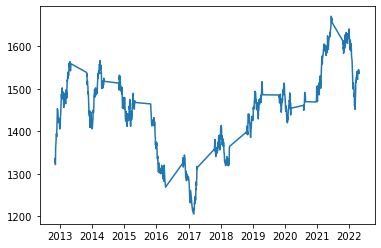

In [16]:
#spot checking to make sure elo ratings make sense
brooklyn_df = team_boxscores_df[team_boxscores_df['TEAM_CITY']=='Brooklyn']
plt.plot(brooklyn_df['GAME_DATE'], brooklyn_df['ELO'])

In [17]:
#calculate win percentage over last n games inplace of WL column
win_pct = np.empty(len(team_boxscores_df))
num_games = 10

for i, row in tqdm(team_boxscores_df.iterrows()):
    team_id = row['TEAM_ID']
    game_date = row['GAME_DATE']
    
    temp_df = team_boxscores_df[(team_boxscores_df['TEAM_ID'] == team_id) &
                               (team_boxscores_df['GAME_DATE'] < game_date)].copy()
    temp_df.sort_values(by=['GAME_DATE'], ascending=True, inplace=True)
    temp_df = temp_df.tail(num_games)
    
    if len(temp_df) < num_games:
        win_pct[i] = 0.5
    else:
        win_pct[i] = np.mean(temp_df['WL'])

team_boxscores_df['RECENT_WIN_PCT'] = win_pct

56308it [03:36, 259.67it/s]


In [18]:
#take exponentially weighted moving average of stats for each game
num_games = 50
alpha = 0.3

exclude_cols = {'SEASON', 
                'TEAM_ID', 
                'GAME_ID', 
                'GAME_DATE', 
                'HOME_TEAM', 
                'TEAM_CITY', 
                'ELO',
                'WL',
                'RECENT_WIN_PCT'}
feature_cols = set(team_boxscores_df.columns) - exclude_cols

weighted_avgs = []

for i, row in tqdm(team_boxscores_df.iterrows()):
    team_id = row['TEAM_ID']
    game_date = row['GAME_DATE']

    temp_df = team_boxscores_df[(team_boxscores_df['TEAM_ID'] == team_id) &
                                (team_boxscores_df['GAME_DATE'] < game_date)].copy()
    temp_df.sort_values(by=['GAME_DATE'], ascending=True, inplace=True)
    temp_df = temp_df.tail(num_games)
    
    #if less than num_games available, continue to next iteration
    if len(temp_df) < num_games:
        continue
    
    temp_df[list(feature_cols)] = temp_df[list(feature_cols)].ewm(alpha=alpha).mean()
    
    row[list(feature_cols)] = temp_df.iloc[-1]
    
    weighted_avgs.append(row)

weighted_avg_df = pd.DataFrame(weighted_avgs)
weighted_avg_df.reset_index(drop=True, inplace=True)

56308it [13:35, 69.01it/s]


In [19]:
weighted_avg_df.head()

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM,ELO,RECENT_WIN_PCT
0,2000-01,1610612760,0020000689,2001-02-05,1,241.260525,35.048408,73.383177,0.477966,5.615793,11.445383,0.517110,20.719505,29.104307,0.714005,10.412029,28.049644,38.461673,20.837067,8.026003,3.600310,18.720610,20.286565,96.432114,-5.228264,Seattle,101.930059,103.625720,108.301429,109.445989,-6.362231,-5.820219,0.595459,1.141096,16.432964,0.300457,0.694145,0.498374,19.840594,20.165518,0.515955,0.559680,1.0,0.197649,93.828321,92.530013,77.108981,92.971467,0.452468,True,1321.428336,0.6
1,2000-01,1610612760,0020000704,2001-02-07,0,240.882368,36.233886,75.968224,0.477376,5.431055,12.811768,0.455877,18.103653,26.373015,0.679803,11.188420,28.034751,39.223171,22.385947,9.218202,4.920217,17.604427,19.600595,96.002480,0.240215,Seattle,102.071041,103.528004,103.291000,103.342192,-1.243562,0.155847,0.616921,1.317767,17.413075,0.306020,0.725902,0.506554,18.737616,19.005863,0.512968,0.548676,1.0,0.197454,93.021824,92.371009,76.977287,92.680027,0.487728,False,1325.541563,0.7
2,2000-01,1610612751,0020000706,2001-02-08,1,240.000000,32.047657,80.061875,0.399108,4.024035,12.949825,0.301188,22.723392,29.550160,0.767270,11.835681,27.999785,39.835466,18.893504,8.472522,6.804395,13.991598,27.487057,90.842740,-3.713075,New Jersey,95.244796,96.936875,99.317192,101.452164,-4.104813,-4.482416,0.593443,1.502725,14.934888,0.292872,0.680244,0.472847,14.688032,14.974316,0.423788,0.486789,1.0,0.197232,95.256699,93.376672,77.814156,93.546196,0.451886,True,1158.589256,0.3
3,2000-01,1610612766,0020000707,2001-02-08,1,240.160069,31.739719,78.799035,0.404722,3.709789,11.143718,0.321779,17.558397,24.129806,0.729002,12.080927,29.267830,41.348757,18.406745,8.353031,5.414921,14.668696,19.958904,84.747625,-10.333468,Charlotte,92.250985,91.777577,102.281610,103.031886,-10.035578,-11.261991,0.575795,1.340702,14.913884,0.276520,0.712798,0.488421,15.921032,15.850780,0.428257,0.475082,1.0,0.199402,92.460307,92.343486,76.952847,92.442152,0.429180,True,1299.264022,0.2
4,2000-01,1610612743,0020000708,2001-02-08,0,240.000386,34.032028,79.586072,0.427243,6.354644,17.919068,0.371371,16.693781,21.802713,0.746335,11.573652,32.597712,44.171364,22.065659,6.095442,6.381445,15.684900,21.794140,91.112482,-7.980772,Denver,97.561619,97.695490,105.086805,106.636335,-7.494435,-8.911440,0.642789,1.494760,17.256820,0.283278,0.718621,0.502865,16.843439,16.816810,0.467142,0.509672,1.0,0.198562,93.824313,93.085469,77.570669,93.221469,0.446210,False,1312.520179,0.3


In [20]:
#add number of rest days
rest_days = np.empty(weighted_avg_df.shape[0])

for i, row in tqdm(weighted_avg_df.iterrows()):
    game_date = row['GAME_DATE']
    team_id = row['TEAM_ID']
    rest_days_df = weighted_avg_df[(weighted_avg_df['TEAM_ID'] == team_id) &
                                     (weighted_avg_df['GAME_DATE'] < game_date)].copy()
    if len(rest_days_df) == 0:
        #if no previous games, default rest days to 3
        rest_days[i] = 3
        continue
    
    rest_days_df.sort_values(by=['GAME_DATE'], ascending=False, inplace=True, ignore_index=True)
    last_game_date = rest_days_df.iloc[0]['GAME_DATE']
    
    #to limit high variance in rest days due to off-season and all-star break, set max number of rest days to 3
    delta = min((game_date - last_game_date).days, 3)
    rest_days[i] = delta
    
weighted_avg_df['REST_DAYS'] = rest_days

54808it [03:44, 244.14it/s]


In [21]:
#QA rest days
weighted_avg_df[weighted_avg_df['TEAM_ID']==1610612744].sort_values(by=['GAME_DATE'])

,SEASON,TEAM_ID,GAME_ID,GAME_DATE,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,TEAM_CITY,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,HOME_TEAM,ELO,RECENT_WIN_PCT,REST_DAYS
37,2000-01,1610612744,0020000741,2001-02-16,0,240.000120,34.879167,88.530717,0.394805,3.942300,13.944302,0.283057,14.275143,21.471872,0.657341,14.646312,31.364978,46.011290,21.619584,9.385139,4.970383,14.316173,19.918553,87.975777,-9.421846,Golden State,90.175253,91.950272,102.152225,101.594163,-11.971054,-9.630554,0.618906,1.586514,16.121314,0.303724,0.755023,0.501401,14.643666,14.936230,0.417871,0.450456,1.0,0.200023,96.561404,95.797720,79.832998,95.717479,0.416980,True,1174.492742,0.2,3.0
63,2000-01,1610612744,0020000756,2001-02-18,0,240.000084,34.315417,85.971502,0.400263,3.059610,13.361011,0.223040,13.592600,19.230310,0.717239,15.052418,30.055485,45.107903,21.733709,8.969597,3.779268,16.021321,19.642987,85.283044,-10.495292,Golden State,89.402677,91.305191,102.106557,102.135914,-12.699738,-10.821388,0.633334,1.440560,16.444920,0.333807,0.766751,0.527693,16.905466,17.265361,0.418209,0.452719,1.0,0.200016,94.640983,93.608404,78.008099,93.402235,0.418786,True,1160.076977,0.2,2.0
78,2000-01,1610612744,0020000765,2001-02-20,0,240.000059,34.220792,88.680052,0.387584,3.641727,13.852708,0.256028,14.914820,21.261217,0.709667,17.436693,31.238839,48.675532,20.913596,8.678718,3.245488,16.014925,21.250091,86.998131,-9.446704,Golden State,90.031874,91.483633,100.904590,101.195140,-10.869816,-9.704971,0.611034,1.365392,15.531444,0.351865,0.768544,0.530706,16.660826,16.945753,0.407947,0.445004,1.0,0.200311,96.152688,95.225883,79.355669,95.081565,0.410450,False,1150.450621,0.1,2.0
108,2000-01,1610612744,0020000780,2001-02-22,0,240.000041,36.554554,90.876036,0.402709,3.449209,12.996895,0.261120,14.940374,22.382852,0.676767,17.305685,29.667187,46.972872,23.639517,9.375103,5.271841,14.810447,19.975064,91.498691,-9.912693,Golden State,93.022312,96.258543,106.423213,106.896598,-13.398872,-10.633480,0.641924,1.705774,16.902011,0.380705,0.712881,0.524194,15.192078,15.642027,0.421463,0.454602,1.0,0.199618,96.808881,95.008118,79.173968,95.057095,0.426815,False,1147.291823,0.1,2.0
126,2000-01,1610612744,0020000789,2001-02-23,0,240.000029,36.388188,89.713225,0.406096,3.914446,11.797827,0.349584,14.658262,20.467996,0.736237,15.113979,28.267031,43.381011,23.147662,9.562572,4.290289,13.667313,18.482545,91.349084,-7.538885,Golden State,93.825618,96.120980,103.836249,103.897619,-10.009210,-7.773436,0.632647,1.794042,17.021408,0.330094,0.703617,0.495036,14.106655,14.429419,0.427924,0.463422,1.0,0.199732,96.284217,95.155683,79.295778,95.039967,0.430471,False,1145.949465,0.1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54799,2021-22,1610612744,0042100402,2022-06-05,1,240.000000,41.495690,86.330988,0.481767,14.510152,36.837216,0.391873,14.890881,18.821564,0.795655,11.306656,33.825134,45.131790,28.088347,6.190114,4.389608,13.060761,19.351752,112.392412,-0.144333,Golden State,116.885750,117.703009,115.915367,118.898307,0.963570,-1.180037,0.674378,2.303795,20.621900,0.307232,0.786271,0.549091,13.505357,13.644127,0.565605,0.594635,1.0,0.197872,96.750064,95.170992,79.309662,95.599962,0.509969,True,1672.682633,0.7,3.0
54800,2021-22,1610612744,0042100403,2022-06-08,0,240.000000,40.746983,86.231691,0.473137,14.657106,36.886051,0.395811,14.623617,19.175095,0.766959,9.714659,34.477594,44.192253,27.161843,8.833080,3.672725,12.742533,18.646227,110.774688,5.598967,Golden State,113.680025,115.482106,107.420757,110.168815,6.254499,5.323974,0.664364,2.236656,20.135330,0.282262,0.784390,0.535863,13.025250,13.270

In [22]:
#reformat so each game is represented by a single row
home_df = weighted_avg_df[weighted_avg_df['HOME_TEAM']==True]
away_df = weighted_avg_df[weighted_avg_df['HOME_TEAM']==False]

boxscore_df = home_df.merge(away_df, on='GAME_ID', how='inner', suffixes=('_HOME', '_AWAY'))
boxscore_df.head()

,SEASON_HOME,TEAM_ID_HOME,GAME_ID,GAME_DATE_HOME,WL_HOME,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,TEAM_CITY_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,HOME_TEAM_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,SEASON_AWAY,TEAM_ID_AWAY,GAME_DATE_AWAY,WL_AWAY,MIN_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,TEAM_CITY_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,HOME_TEAM_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY
0,2000-01,1610612748,0020000711,2001-02-13,1,247.835208,35.079987,77.049908,0.453872,6.055312,16.602300,0.376412,20.846411,26.904838,0.762621,10.792549,30.993098,41.785647,19.629887,6.624407,3.686947,12.814775,21.112283,97.061696,8.001023,Miami,106.996534,107.503511,97.743774,99.460703,9.216214,8.047928,0.563001,1.635811,16.158846,0.292515,0.730916,0.516261,14.063769,14.107728,0.493354,0.545781,1.0,0.198609,88.231094,87.286286,72.739387,90.561427,0.572014,True,1396.531075,0.7,3.0,2000-01,1610612746,2001-02-13,0,240.626989,37.214224,79.290064,0.471073,3.879021,11.699011,0.330758,12.306191,19.454056,0.652737,11.664554,32.875999,44.540553,19.200907,6.232806,7.315007,14.851292,21.033333,90.613660,1.681682,Los Angeles,99.629300,103.141185,99.842546,100.787803,-0.200663,2.346578,0.516195,1.423155,15.735083,0.309575,0.671026,0.501276,16.203042,16.785645,0.495161,0.517598,1.0,0.197260,89.881984,87.891121,73.244095,87.930318,0.499036,False,1208.524359,0.3,3.0
1,2000-01,1610612757,0020000721,2001-02-13,1,240.005994,36.942018,79.630111,0.464927,3.987866,9.745421,0.414469,15.092363,20.542021,0.717404,13.490158,29.328736,42.818895,21.108783,7.867043,4.236678,13.950038,17.203741,92.964264,6.503731,Portland,103.990709,104.383004,97.344764,97.797148,6.648110,6.575875,0.575400,1.553488,16.993127,0.341034,0.698270,0.522410,15.583457,15.629145,0.489989,0.524994,1.0,0.198756,89.080252,88.746914,73.956321,89.014321,0.546707,True,1413.853474,0.6,3.0,2000-01,1610612750,2001-02-13,0,240.000950,41.610419,81.583197,0.507676,4.666862,11.672336,0.367010,16.227977,19.154803,0.865114,10.704400,32.257693,42.962093,30.083835,7.726657,7.846619,15.072937,24.573187,104.115677,13.534241,Minnesota,110.259629,111.903000,96.591537,97.684754,13.644083,14.220177,0.721309,2.048067,22.075403,0.286551,0.682142,0.514842,15.934603,16.167452,0.536262,0.578384,1.0,0.198587,94.105838,92.943031,77.451454,92.993362,0.595863,False,1385.270634,1.0,3.0
2,2000-01,1610612765,0020000726,2001-02-14,1,243.680984,35.492678,87.498403,0.407524,4.664168,12.930955,0.348124,17.443740,23.093474,0.760732,14.229996,31.617499,45.847495,18.651178,7.544023,3.987540,14.569207,21.665473,93.093264,-2.242138,Detroit,95.066975,98.079574,100.747896,100.463983,-5.694300,-2.394948,0.523149,1.341266,14.207603,0.345168,0.767114,0.527290,14.810068,15.312812,0.434377,0.477799,1.0,0.198388,95.005588,93.555721,77.963884,94.912513,0.468122,True,1194.196873,0.4,3.0,2000-01,1610612751,2001-02-14,0,247.500000,34.543352,81.110319,0.424823,5.841777,13.965414,0.411312,23.374462,30.379578,0.768962,11.199484,28.659895,39.859378,19.127817,8.051536,4.054154,13.365883,27.898658,98.302943,-2.299407,New Jersey,101.563950,104.007069,104.5824

In [25]:
list(boxscore_df.columns)

['SEASON_HOME',
 'TEAM_ID_HOME',
 'GAME_ID',
 'GAME_DATE_HOME',
 'WL_HOME',
 'MIN_HOME',
 'FGM_HOME',
 'FGA_HOME',
 'FG_PCT_HOME',
 'FG3M_HOME',
 'FG3A_HOME',
 'FG3_PCT_HOME',
 'FTM_HOME',
 'FTA_HOME',
 'FT_PCT_HOME',
 'OREB_HOME',
 'DREB_HOME',
 'REB_HOME',
 'AST_HOME',
 'STL_HOME',
 'BLK_HOME',
 'TOV_HOME',
 'PF_HOME',
 'PTS_HOME',
 'PLUS_MINUS_HOME',
 'TEAM_CITY_HOME',
 'E_OFF_RATING_HOME',
 'OFF_RATING_HOME',
 'E_DEF_RATING_HOME',
 'DEF_RATING_HOME',
 'E_NET_RATING_HOME',
 'NET_RATING_HOME',
 'AST_PCT_HOME',
 'AST_TOV_HOME',
 'AST_RATIO_HOME',
 'OREB_PCT_HOME',
 'DREB_PCT_HOME',
 'REB_PCT_HOME',
 'E_TM_TOV_PCT_HOME',
 'TM_TOV_PCT_HOME',
 'EFG_PCT_HOME',
 'TS_PCT_HOME',
 'USG_PCT_HOME',
 'E_USG_PCT_HOME',
 'E_PACE_HOME',
 'PACE_HOME',
 'PACE_PER40_HOME',
 'POSS_HOME',
 'PIE_HOME',
 'HOME_TEAM_HOME',
 'ELO_HOME',
 'RECENT_WIN_PCT_HOME',
 'REST_DAYS_HOME',
 'SEASON_AWAY',
 'TEAM_ID_AWAY',
 'GAME_DATE_AWAY',
 'WL_AWAY',
 'MIN_AWAY',
 'FGM_AWAY',
 'FGA_AWAY',
 'FG_PCT_AWAY',
 'FG3M_AWAY

In [27]:
if format_type == 'team_difference':
    stat_cols = ['MIN',
             'FGM',
             'FGA',
             'FG_PCT',
             'FG3M',
             'FG3A',
             'FG3_PCT',
             'FTM',
             'FTA',
             'FT_PCT',
             'OREB',
             'DREB',
             'REB',
             'AST',
             'STL',
             'BLK',
             'TOV',
             'PF',
             'PTS',
             'PLUS_MINUS',
             'E_OFF_RATING',
             'OFF_RATING',
             'E_DEF_RATING',
             'DEF_RATING',
             'E_NET_RATING',
             'NET_RATING',
             'AST_PCT',
             'AST_TOV',
             'AST_RATIO',
             'OREB_PCT',
             'DREB_PCT',
             'REB_PCT',
             'E_TM_TOV_PCT',
             'TM_TOV_PCT',
             'EFG_PCT',
             'TS_PCT',
             'USG_PCT',
             'E_USG_PCT',
             'E_PACE',
             'PACE',
             'PACE_PER40',
             'POSS',
             'PIE',
             'ELO',
             'RECENT_WIN_PCT',
             'REST_DAYS'] 
    
    for stat in stat_cols:
        boxscore_df[stat] = boxscore_df[stat + '_HOME'] - boxscore_df[stat + '_AWAY']
        boxscore_df.drop(columns = [stat + '_HOME', stat + '_AWAY'], inplace=True)
    

In [28]:
boxscore_df.head()

,SEASON_HOME,TEAM_ID_HOME,GAME_ID,GAME_DATE_HOME,WL_HOME,TEAM_CITY_HOME,HOME_TEAM_HOME,SEASON_AWAY,TEAM_ID_AWAY,GAME_DATE_AWAY,WL_AWAY,TEAM_CITY_AWAY,HOME_TEAM_AWAY,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,ELO,RECENT_WIN_PCT,REST_DAYS
0,2000-01,1610612748,0020000711,2001-02-13,1,Miami,True,2000-01,1610612746,2001-02-13,0,Los Angeles,False,7.208219,-2.134238,-2.240156,-0.017201,2.176291,4.903289,0.045653,8.540219,7.450783,0.109884,-0.872005,-1.882901,-2.754907,0.428980,0.391601,-3.628061,-2.036517,0.078950,6.448036,6.319341,7.367233,4.362325,-2.098772,-1.327101,9.416876,5.701350,0.046806,0.212656,0.423763,-0.017060,0.059890,0.014984,-2.139273,-2.677917,-0.001807,0.028184,0.0,0.001349,-1.650890,-0.604835,-0.504708,2.631109,0.072978,188.006716,0.4,0.0
1,2000-01,1610612757,0020000721,2001-02-13,1,Portland,True,2000-01,1610612750,2001-02-13,0,Minnesota,False,0.005044,-4.668402,-1.953086,-0.042749,-0.678996,-1.926916,0.047459,-1.135614,1.387218,-0.147710,2.785758,-2.928956,-0.143198,-8.975051,0.140386,-3.609940,-1.122899,-7.369445,-11.151413,-7.030511,-6.268919,-7.519997,0.753227,0.112394,-6.995974,-7.644302,-0.145909,-0.494579,-5.082276,0.054483,0.016128,0.007567,-0.351146,-0.538307,-0.046273,-0.053390,0.0,0.000168,-5.025586,-4.196116,-3.495133,-3.979041,-0.049156,28.582841,-0.4,0.0
2,2000-01,1610612765,0020000726,2001-02-14,1,Detroit,True,2000-01,1610612751,2001-02-14,0,New Jersey,False,-3.819016,0.949326,6.388084,-0.017299,-1.177609,-1.034460,-0.063188,-5.930722,-7.286105,-0.008231,3.030513,2.957604,5.988117,-0.476639,-0.507513,-0.066614,1.203324,-6.233185,-5.209679,0.057269,-6.496975,-5.927495,-3.834529,-5.281577,-2.638942,-0.672564,-0.034037,-0.170569,-0.823492,0.058111,0.127975,0.066275,0.992922,1.144397,-0.026089,-0.041258,0.0,0.002024,1.497406,1.688151,1.406448,0.564877,0.005378,31.473465,0.1,2.0
3,2000-01,1610612761,0020000729,2001-02-15,0,Toronto,True,2000-01,1610612748,2001-02-15,1,Miami,False,-11.815092,3.226037,5.631449,0.009815,-1.729657,-4.100229,0.002701,3.927086,4.465215,0.015530,1.885108,1.315453,3.200561,6.770771,-0.436800,2.971966,-2.090210,-0.097108,8.649503,1.276697,4.724125,5.774040,6.884432,4.275166,-2.104937,1.523447,0.123799,1.005292,3.450811,0.018827,0.068467,0.029759,-2.698654,-2.594609,-0.003351,0.002178,0.0,0.000461,6.486750,7.175736,5.978130,2.658387,-0.018644,-53.480896,-0.2,1.0
4,2000-01,1610612760,0020000734,2001-02-15,0,Seattle,True,2000-01,1610612738,2001-02-15,1,Boston,False,-0.643047,0.285536,-5.801444,0.033694,-4.074978,-10.810325,0.037363,-2.987645,-0.014333,-0.121863,3.024193,-1.068035,1.956158,-0.645114,-2.758825,-0.405259,4.017657,-4.113859,-6.491552,-7.189188,-2.029537,-2.571955,7.001078,4.573602,-9.078432,-7.184322,-0.022624,-0.495121,-0.328019,0.100997,0.032721,0.063336,5.054087,5.011590,0.010538,-0.004907,0.0,-0.000237,-5.205952,-3.633370,-3.026269,-4.210276,-0.050333,76.886842,0.0,0.0


In [29]:
#create lookup for team id and team city
team_id_city_lookup = {}
for i, row in boxscore_df.iterrows():
    team_id = row['TEAM_ID_HOME']
    team_city = row['TEAM_CITY_HOME']
    if team_id not in team_id_city_lookup:
        team_id_city_lookup[team_id] = [team_city]
    elif team_city not in team_id_city_lookup[team_id]:
        team_id_city_lookup[team_id].append(team_city)
team_id_city_lookup

{1610612748: ['Miami'],
 1610612757: ['Portland'],
 1610612765: ['Detroit'],
 1610612761: ['Toronto'],
 1610612760: ['Seattle', 'Oklahoma City'],
 1610612755: ['Philadelphia'],
 1610612744: ['Golden State'],
 1610612742: ['Dallas'],
 1610612751: ['New Jersey', 'Brooklyn'],
 1610612753: ['Orlando'],
 1610612754: ['Indiana'],
 1610612750: ['Minnesota'],
 1610612743: ['Denver'],
 1610612739: ['Cleveland'],
 1610612749: ['Milwaukee'],
 1610612762: ['Utah'],
 1610612752: ['New York'],
 1610612764: ['Washington'],
 1610612741: ['Chicago'],
 1610612745: ['Houston'],
 1610612758: ['Sacramento'],
 1610612759: ['San Antonio'],
 1610612766: ['Charlotte'],
 1610612747: ['Los Angeles'],
 1610612746: ['Los Angeles', 'LA'],
 1610612756: ['Phoenix'],
 1610612738: ['Boston'],
 1610612763: ['Vancouver', 'Memphis'],
 1610612737: ['Atlanta'],
 1610612740: ['New Orleans', 'New Orleans/Oklahoma City']}

In [30]:
print(list(boxscore_df.columns))

['SEASON_HOME', 'TEAM_ID_HOME', 'GAME_ID', 'GAME_DATE_HOME', 'WL_HOME', 'TEAM_CITY_HOME', 'HOME_TEAM_HOME', 'SEASON_AWAY', 'TEAM_ID_AWAY', 'GAME_DATE_AWAY', 'WL_AWAY', 'TEAM_CITY_AWAY', 'HOME_TEAM_AWAY', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING', 'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING', 'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE', 'ELO', 'RECENT_WIN_PCT', 'REST_DAYS']


In [31]:
#drop unnecessary columns
boxscore_df.drop(columns=['SEASON_AWAY',
                          'GAME_DATE_AWAY',
                          'WL_AWAY',
                          'WL_HOME',
                          'HOME_TEAM_HOME',
                          'HOME_TEAM_AWAY'], inplace=True)
boxscore_df.head()

,SEASON_HOME,TEAM_ID_HOME,GAME_ID,GAME_DATE_HOME,TEAM_CITY_HOME,TEAM_ID_AWAY,TEAM_CITY_AWAY,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,ELO,RECENT_WIN_PCT,REST_DAYS
0,2000-01,1610612748,0020000711,2001-02-13,Miami,1610612746,Los Angeles,7.208219,-2.134238,-2.240156,-0.017201,2.176291,4.903289,0.045653,8.540219,7.450783,0.109884,-0.872005,-1.882901,-2.754907,0.428980,0.391601,-3.628061,-2.036517,0.078950,6.448036,6.319341,7.367233,4.362325,-2.098772,-1.327101,9.416876,5.701350,0.046806,0.212656,0.423763,-0.017060,0.059890,0.014984,-2.139273,-2.677917,-0.001807,0.028184,0.0,0.001349,-1.650890,-0.604835,-0.504708,2.631109,0.072978,188.006716,0.4,0.0
1,2000-01,1610612757,0020000721,2001-02-13,Portland,1610612750,Minnesota,0.005044,-4.668402,-1.953086,-0.042749,-0.678996,-1.926916,0.047459,-1.135614,1.387218,-0.147710,2.785758,-2.928956,-0.143198,-8.975051,0.140386,-3.609940,-1.122899,-7.369445,-11.151413,-7.030511,-6.268919,-7.519997,0.753227,0.112394,-6.995974,-7.644302,-0.145909,-0.494579,-5.082276,0.054483,0.016128,0.007567,-0.351146,-0.538307,-0.046273,-0.053390,0.0,0.000168,-5.025586,-4.196116,-3.495133,-3.979041,-0.049156,28.582841,-0.4,0.0
2,2000-01,1610612765,0020000726,2001-02-14,Detroit,1610612751,New Jersey,-3.819016,0.949326,6.388084,-0.017299,-1.177609,-1.034460,-0.063188,-5.930722,-7.286105,-0.008231,3.030513,2.957604,5.988117,-0.476639,-0.507513,-0.066614,1.203324,-6.233185,-5.209679,0.057269,-6.496975,-5.927495,-3.834529,-5.281577,-2.638942,-0.672564,-0.034037,-0.170569,-0.823492,0.058111,0.127975,0.066275,0.992922,1.144397,-0.026089,-0.041258,0.0,0.002024,1.497406,1.688151,1.406448,0.564877,0.005378,31.473465,0.1,2.0
3,2000-01,1610612761,0020000729,2001-02-15,Toronto,1610612748,Miami,-11.815092,3.226037,5.631449,0.009815,-1.729657,-4.100229,0.002701,3.927086,4.465215,0.015530,1.885108,1.315453,3.200561,6.770771,-0.436800,2.971966,-2.090210,-0.097108,8.649503,1.276697,4.724125,5.774040,6.884432,4.275166,-2.104937,1.523447,0.123799,1.005292,3.450811,0.018827,0.068467,0.029759,-2.698654,-2.594609,-0.003351,0.002178,0.0,0.000461,6.486750,7.175736,5.978130,2.658387,-0.018644,-53.480896,-0.2,1.0
4,2000-01,1610612760,0020000734,2001-02-15,Seattle,1610612738,Boston,-0.643047,0.285536,-5.801444,0.033694,-4.074978,-10.810325,0.037363,-2.987645,-0.014333,-0.121863,3.024193,-1.068035,1.956158,-0.645114,-2.758825,-0.405259,4.017657,-4.113859,-6.491552,-7.189188,-2.029537,-2.571955,7.001078,4.573602,-9.078432,-7.184322,-0.022624,-0.495121,-0.328019,0.100997,0.032721,0.063336,5.054087,5.011590,0.010538,-0.004907,0.0,-0.000237,-5.205952,-3.633370,-3.026269,-4.210276,-0.050333,76.886842,0.0,0.0


In [32]:
#add actual point spreads back to boxscore data
final_df = boxscore_df.merge(game_spreads_df, on='GAME_ID', how='inner')
final_df.rename(columns={'SPREAD':'GAME_SPREAD', 'SEASON_HOME':'SEASON', 'GAME_DATE_HOME':'GAME_DATE'}, inplace=True)
final_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,TEAM_CITY_HOME,TEAM_ID_AWAY,TEAM_CITY_AWAY,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,ELO,RECENT_WIN_PCT,REST_DAYS,GAME_SPREAD
0,2000-01,1610612748,0020000711,2001-02-13,Miami,1610612746,Los Angeles,7.208219,-2.134238,-2.240156,-0.017201,2.176291,4.903289,0.045653,8.540219,7.450783,0.109884,-0.872005,-1.882901,-2.754907,0.428980,0.391601,-3.628061,-2.036517,0.078950,6.448036,6.319341,7.367233,4.362325,-2.098772,-1.327101,9.416876,5.701350,0.046806,0.212656,0.423763,-0.017060,0.059890,0.014984,-2.139273,-2.677917,-0.001807,0.028184,0.0,0.001349,-1.650890,-0.604835,-0.504708,2.631109,0.072978,188.006716,0.4,0.0,2.0
1,2000-01,1610612757,0020000721,2001-02-13,Portland,1610612750,Minnesota,0.005044,-4.668402,-1.953086,-0.042749,-0.678996,-1.926916,0.047459,-1.135614,1.387218,-0.147710,2.785758,-2.928956,-0.143198,-8.975051,0.140386,-3.609940,-1.122899,-7.369445,-11.151413,-7.030511,-6.268919,-7.519997,0.753227,0.112394,-6.995974,-7.644302,-0.145909,-0.494579,-5.082276,0.054483,0.016128,0.007567,-0.351146,-0.538307,-0.046273,-0.053390,0.0,0.000168,-5.025586,-4.196116,-3.495133,-3.979041,-0.049156,28.582841,-0.4,0.0,21.0
2,2000-01,1610612765,0020000726,2001-02-14,Detroit,1610612751,New Jersey,-3.819016,0.949326,6.388084,-0.017299,-1.177609,-1.034460,-0.063188,-5.930722,-7.286105,-0.008231,3.030513,2.957604,5.988117,-0.476639,-0.507513,-0.066614,1.203324,-6.233185,-5.209679,0.057269,-6.496975,-5.927495,-3.834529,-5.281577,-2.638942,-0.672564,-0.034037,-0.170569,-0.823492,0.058111,0.127975,0.066275,0.992922,1.144397,-0.026089,-0.041258,0.0,0.002024,1.497406,1.688151,1.406448,0.564877,0.005378,31.473465,0.1,2.0,19.0
3,2000-01,1610612761,0020000729,2001-02-15,Toronto,1610612748,Miami,-11.815092,3.226037,5.631449,0.009815,-1.729657,-4.100229,0.002701,3.927086,4.465215,0.015530,1.885108,1.315453,3.200561,6.770771,-0.436800,2.971966,-2.090210,-0.097108,8.649503,1.276697,4.724125,5.774040,6.884432,4.275166,-2.104937,1.523447,0.123799,1.005292,3.450811,0.018827,0.068467,0.029759,-2.698654,-2.594609,-0.003351,0.002178,0.0,0.000461,6.486750,7.175736,5.978130,2.658387,-0.018644,-53.480896,-0.2,1.0,-7.0
4,2000-01,1610612760,0020000734,2001-02-15,Seattle,1610612738,Boston,-0.643047,0.285536,-5.801444,0.033694,-4.074978,-10.810325,0.037363,-2.987645,-0.014333,-0.121863,3.024193,-1.068035,1.956158,-0.645114,-2.758825,-0.405259,4.017657,-4.113859,-6.491552,-7.189188,-2.029537,-2.571955,7.001078,4.573602,-9.078432,-7.184322,-0.022624,-0.495121,-0.328019,0.100997,0.032721,0.063336,5.054087,5.011590,0.010538,-0.004907,0.0,-0.000237,-5.205952,-3.633370,-3.026269,-4.210276,-0.050333,76.886842,0.0,0.0,-20.0


In [33]:
#drop unneeded columns
if format_type == 'concat':
    final_df.drop(columns=['USG_PCT_HOME',
                          'E_USG_PCT_HOME',
                          'USG_PCT_AWAY',
                          'E_USG_PCT_AWAY',
                          'MIN_HOME',
                          'MIN_AWAY'], inplace=True)
elif format_type == 'team_difference':
    final_df.drop(columns=['USG_PCT',
                          'E_USG_PCT',
                          'MIN'], inplace=True)
final_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,TEAM_CITY_HOME,TEAM_ID_AWAY,TEAM_CITY_AWAY,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,ELO,RECENT_WIN_PCT,REST_DAYS,GAME_SPREAD
0,2000-01,1610612748,0020000711,2001-02-13,Miami,1610612746,Los Angeles,-2.134238,-2.240156,-0.017201,2.176291,4.903289,0.045653,8.540219,7.450783,0.109884,-0.872005,-1.882901,-2.754907,0.428980,0.391601,-3.628061,-2.036517,0.078950,6.448036,6.319341,7.367233,4.362325,-2.098772,-1.327101,9.416876,5.701350,0.046806,0.212656,0.423763,-0.017060,0.059890,0.014984,-2.139273,-2.677917,-0.001807,0.028184,-1.650890,-0.604835,-0.504708,2.631109,0.072978,188.006716,0.4,0.0,2.0
1,2000-01,1610612757,0020000721,2001-02-13,Portland,1610612750,Minnesota,-4.668402,-1.953086,-0.042749,-0.678996,-1.926916,0.047459,-1.135614,1.387218,-0.147710,2.785758,-2.928956,-0.143198,-8.975051,0.140386,-3.609940,-1.122899,-7.369445,-11.151413,-7.030511,-6.268919,-7.519997,0.753227,0.112394,-6.995974,-7.644302,-0.145909,-0.494579,-5.082276,0.054483,0.016128,0.007567,-0.351146,-0.538307,-0.046273,-0.053390,-5.025586,-4.196116,-3.495133,-3.979041,-0.049156,28.582841,-0.4,0.0,21.0
2,2000-01,1610612765,0020000726,2001-02-14,Detroit,1610612751,New Jersey,0.949326,6.388084,-0.017299,-1.177609,-1.034460,-0.063188,-5.930722,-7.286105,-0.008231,3.030513,2.957604,5.988117,-0.476639,-0.507513,-0.066614,1.203324,-6.233185,-5.209679,0.057269,-6.496975,-5.927495,-3.834529,-5.281577,-2.638942,-0.672564,-0.034037,-0.170569,-0.823492,0.058111,0.127975,0.066275,0.992922,1.144397,-0.026089,-0.041258,1.497406,1.688151,1.406448,0.564877,0.005378,31.473465,0.1,2.0,19.0
3,2000-01,1610612761,0020000729,2001-02-15,Toronto,1610612748,Miami,3.226037,5.631449,0.009815,-1.729657,-4.100229,0.002701,3.927086,4.465215,0.015530,1.885108,1.315453,3.200561,6.770771,-0.436800,2.971966,-2.090210,-0.097108,8.649503,1.276697,4.724125,5.774040,6.884432,4.275166,-2.104937,1.523447,0.123799,1.005292,3.450811,0.018827,0.068467,0.029759,-2.698654,-2.594609,-0.003351,0.002178,6.486750,7.175736,5.978130,2.658387,-0.018644,-53.480896,-0.2,1.0,-7.0
4,2000-01,1610612760,0020000734,2001-02-15,Seattle,1610612738,Boston,0.285536,-5.801444,0.033694,-4.074978,-10.810325,0.037363,-2.987645,-0.014333,-0.121863,3.024193,-1.068035,1.956158,-0.645114,-2.758825,-0.405259,4.017657,-4.113859,-6.491552,-7.189188,-2.029537,-2.571955,7.001078,4.573602,-9.078432,-7.184322,-0.022624,-0.495121,-0.328019,0.100997,0.032721,0.063336,5.054087,5.011590,0.010538,-0.004907,-5.205952,-3.633370,-3.026269,-4.210276,-0.050333,76.886842,0.0,0.0,-20.0


In [34]:
final_df.describe()

,TEAM_ID_HOME,TEAM_ID_AWAY,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,ELO,RECENT_WIN_PCT,REST_DAYS,GAME_SPREAD
count,2.736500e+04,2.736500e+04,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000,27365.000000
mean,1.610613e+09,1.610613e+09,-0.065967,-0.076975,-0.000343,-0.006656,0.021976,-0.000587,-0.039300,-0.049813,-0.000060,-0.038788,-0.042515,-0.081303,-0.052438,-0.021943,-0.009268,0.011037,0.034710,-0.177889,-0.213365,-0.126953,-0.132607,0.080646,0.090343,-0.207344,-0.223008,-0.000364,-0.006332,-0.020997,-0.000812,-0.000467,-0.000699,0.018242,0.018222,-0.000342,-0.000354,-0.041827,-0.043104,-0.035917,-0.045277,-0.001486,0.409311,-0.004191,0.198538,2.935136
std,8.616911e+00,8.617047e+00,3.607949,5.373053,0.037586,2.812732,6.326244,0.070339,4.263670,5.336290,0.070682,2.778505,3.603723,4.467890,3.816175,2.032102,1.848922,2.664915,3.084844,8.902485,10.009439,7.845297,7.699610,7.679025,7.527717,10.908452,10.422523,0.079555,0.495017,2.431371,0.054397,0.047617,0.035630,2.611384,2.675133,0.044396,0.041759,4.231467,4.179325,3.482766,4.451149,0.073016,170.955644,0.289152,0.826322,13.399945
min,1.610613e+09,1.610613e+09,-15.126374,-22.356829,-0.140528,-12.547545,-27.998822,-0.298084,-18.973410,-22.848517,-0.292944,-14.835496,-15.048217,-17.322936,-18.623328,-8.302249,-8.339802,-11.579107,-12.201842,-43.118162,-39.641570,-31.903395,-30.651204,-29.563584,-29.450569,-42.732229,-40.724686,-0.323510,-4.616966,-11.071423,-0.235340,-0.179844,-0.167459,-12.536047,-12.817603,-0.174503,-0.171287,-22.088074,-22.478689,-18.734383,-22.995687,-0.310664,-640.916350,-1.000000,-2.000000,-58.000000
25%,1.610613e+09,1.610613e+09,-2.453797,-3.665221,-0.025735,-1.868099,-4.229995,-0.045415,-2.894003,-3.660031,-0.047077,-1.877146,-2.485289,-3.063890,-2.597692,-1.401560,-1.234116,-1.794431,-2.033387,-6.110012,-6.929007,-5.372644,-5.313804,-5.116315,-4.999854,-7.542614,-7.216070,-0.054251,-0.309403,-1.660833,-0.036813,-0.032430,-0.024409,-1.745378,-1.783923,-0.030450,-0.028544,-2.786019,-2.749899,-2.293373,-2.909796,-0.050432,-115.929803,-0.200000,0.000000,-6.000000
50%,1.610613e+09,1.610613e+09,-0.081883,-0.057666,-0.000366,-0.011424,0.043095,-0.000513,-0.008664,-0.031266,0.000645,-0.034509,-0.019200,-0.084536,-0.054037,-0.033789,0.002249,0.000645,0.040069,-0.146454,-0.192017,-0.095677,-0.117884,0.070073,0.075108,-0.127892,-0.182887,-0.000384,-0.003035,-0.026505,-0.000845,-0.000656,-0.000624,-0.003771,-0.014563,-0.000396,-0.000381,-0.035987,-0.033828,-0.029205,-0.047739,-0.000650,0.587591,0.000000,0.000000,4.000000
75%,1.610613e+09,1.610613e+09,2.360624,3.499235,0.025278,1.871143,4.255660,0.044700,2.792730,3.580595,0.047380,1.830689,2.377664,2.918848,2.473205,1.371709,1.220799,1.821692,2.120734,5.734967,6.527091,5.176861,5.042504,5.318013,5.164106,7.144941,6.789985,0.053406,0.299287,1.600666,0.036056,0.031601,0.023007,1.776749,1.808567,0.029602,0.028066,2.696444,2.681505,2.235051,2.829407,0.047469,116.695608,0.200000,1.000000,12.000000
max,1.610613e+09,1.610613e+09,16.354464,23.711197,0.145023,11.032874,28.077632,0.419888,17.007876,23.053565,0.274308,13.488604,18.164924,18.811239,15.555165,7.746326,8.103956,12.250767,13.569707,39.611152,45.431355,30.127479,29.903386,27.664218,28.497396,48.891062,50.071311,0.324119,6

array([[<AxesSubplot:title={'center':'TEAM_ID_HOME'}>,
        <AxesSubplot:title={'center':'GAME_DATE'}>,
        <AxesSubplot:title={'center':'TEAM_ID_AWAY'}>,
        <AxesSubplot:title={'center':'FGM'}>,
        <AxesSubplot:title={'center':'FGA'}>,
        <AxesSubplot:title={'center':'FG_PCT'}>,
        <AxesSubplot:title={'center':'FG3M'}>],
       [<AxesSubplot:title={'center':'FG3A'}>,
        <AxesSubplot:title={'center':'FG3_PCT'}>,
        <AxesSubplot:title={'center':'FTM'}>,
        <AxesSubplot:title={'center':'FTA'}>,
        <AxesSubplot:title={'center':'FT_PCT'}>,
        <AxesSubplot:title={'center':'OREB'}>,
        <AxesSubplot:title={'center':'DREB'}>],
       [<AxesSubplot:title={'center':'REB'}>,
        <AxesSubplot:title={'center':'AST'}>,
        <AxesSubplot:title={'center':'STL'}>,
        <AxesSubplot:title={'center':'BLK'}>,
        <AxesSubplot:title={'center':'TOV'}>,
        <AxesSubplot:title={'center':'PF'}>,
        <AxesSubplot:title={'center':'PTS

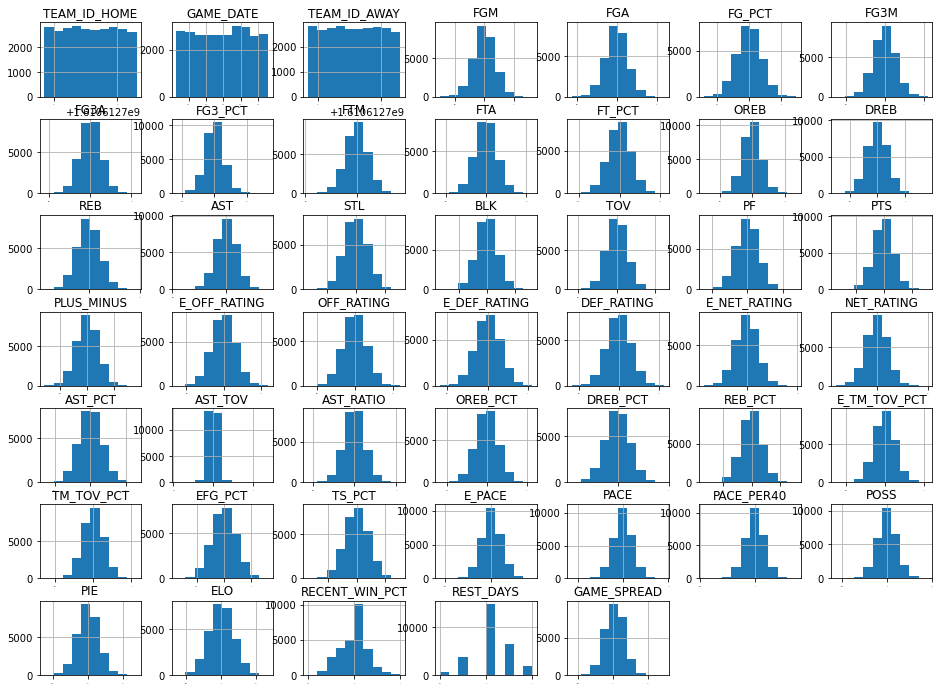

In [35]:
#check distribution of data
final_df.hist(figsize=(16,12), xlabelsize=0)

In [36]:
def check_missing_vals(df):
    cols_w_missing_vals = []
    for col in df.columns:
        if df[col].isna().sum() != 0:
            cols_w_missing_vals.append(col)
    return cols_w_missing_vals

In [37]:
check_missing_vals(final_df)

[]

In [38]:
final_df.to_csv('data_{}_alpha_{}_games_{}.csv'.format(format_type, alpha, num_games))
print('Data converted to csv')
print('Runtime : ', datetime.now() - start_time)

Data converted to csv
Runtime :  1:27:57.980370


## IGNORE BELOW

In [27]:
#import betting spreads data
book_spreads_df = pd.read_csv('spreads_df.csv')
book_spreads_df.drop(columns=['Unnamed: 0'], inplace=True)
book_spreads_df.head()

,GM_DATE,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME
0,2021-10-19,Milwaukee,+1½,-110,+2,-113,+2,-113,+2½,-135,-1½,-110,-2,-108,-2,-108,-2½,-105
1,2021-10-19,L.A. Lakers,+3,-110,+3,-112,+3,-112,+4,-135,-3,-110,-3,-109,-3,-109,-4,-105
2,2021-10-20,Charlotte,-1,+100,+½,-110,+1½,-110,-1½,-110,+1,-120,-½,-110,-1½,-112,+1½,-110
3,2021-10-20,Detroit,-5,-110,-5,-112,-5,-112,-5,-110,+5,-110,+5,-110,+5,-110,+5,-110
4,2021-10-20,Toronto,+2½,-110,+2½,-109,+3,-109,+4½,-160,-2½,-110,-2½,-112,-3,-112,-4½,+115


In [28]:
#clean up lookup table to align team ids with team city names from sportsbooks
team_id_city_lookup[1610612747] = ['L.A. Lakers']
team_id_city_lookup[1610612746] = ['L.A. Clippers']
team_id_city_lookup[1610612760] = ['Oklahoma City']
team_id_city_lookup[1610612751] = ['Brooklyn']
team_id_city_lookup[1610612763] = ['Memphis']
team_id_city_lookup[1610612740] = ['New Orleans']

team_city_id_lookup = {}

for key, val in team_id_city_lookup.items():
    team_city_id_lookup[val[0]] = key

team_city_id_lookup

{'Miami': 1610612748,
 'Portland': 1610612757,
 'Detroit': 1610612765,
 'Toronto': 1610612761,
 'Oklahoma City': 1610612760,
 'Philadelphia': 1610612755,
 'Golden State': 1610612744,
 'Dallas': 1610612742,
 'Brooklyn': 1610612751,
 'Orlando': 1610612753,
 'Indiana': 1610612754,
 'Minnesota': 1610612750,
 'Denver': 1610612743,
 'Cleveland': 1610612739,
 'Milwaukee': 1610612749,
 'Utah': 1610612762,
 'New York': 1610612752,
 'Washington': 1610612764,
 'Chicago': 1610612741,
 'Houston': 1610612745,
 'Sacramento': 1610612758,
 'San Antonio': 1610612759,
 'Charlotte': 1610612766,
 'L.A. Lakers': 1610612747,
 'L.A. Clippers': 1610612746,
 'Phoenix': 1610612756,
 'Boston': 1610612738,
 'Memphis': 1610612763,
 'Atlanta': 1610612737,
 'New Orleans': 1610612740}

In [29]:
#add team ids to sportsbook df
book_spreads_df['TEAM_ID_HOME'] = book_spreads_df.apply(lambda row: team_city_id_lookup[row['HOME_TEAM']], axis=1)

#merge boxscores and sportsbook data
book_spreads_df.rename(columns={'GM_DATE':'GAME_DATE'}, inplace=True)
final_df['GAME_DATE'] = pd.to_datetime(final_df['GAME_DATE'])
book_spreads_df['GAME_DATE'] = pd.to_datetime(book_spreads_df['GAME_DATE'])
final_df = final_df.merge(book_spreads_df, on=['GAME_DATE', 'TEAM_ID_HOME'], how='inner')
final_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,MIN_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME
0,2017-18,1610612739,0021700001,2017-10-17,241.907707,40.965110,83.948117,0.489223,13.676423,34.233172,0.398315,18.124519,23.845221,0.761012,8.950815,33.791341,42.742156,22.596899,6.677717,4.298566,13.209539,18.861876,113.731162,4.085407,115.295871,116.748156,109.801379,112.562227,5.500785,4.190375,0.551902,1.854118,17.295762,0.245495,0.717295,0.493778,13.384724,13.540587,0.571121,0.603226,1.0,0.198253,98.526115,96.664256,80.553048,97.491655,0.516378,1664.024085,0.5,3.0,1610612738,240.759964,38.278699,84.128857,0.455234,12.305075,34.205067,0.359576,17.456237,22.315378,0.784682,9.172299,30.762175,39.934474,26.362172,7.599343,3.964553,13.749201,20.980156,106.318709,-1.569166,108.065598,110.070366,109.507331,111.693323,-1.458513,-1.628263,0.689509,2.140389,19.630402,0.252389,0.709116,0.478167,13.884227,14.172962,0.528242,0.566162,1.0,0.198234,98.244215,96.320377,80.267569,96.666855,0.492077,1540.735485,0.3,3.0,3.0,Cleveland,+4½,-110,+12½,-345,NaN,-,NaN,-,-4½,-110,-12½,+270,NaN,-,NaN,-
1,2017-18,1610612744,0021700002,2017-10-17,240.166179,42.786234,86.941411,0.493566,12.430904,32.432811,0.384523,18.696132,23.329725,0.804430,9.806858,34.990726,44.797584,28.794414,9.054398,6.361524,14.134830,20.964238,116.699504,11.541095,114.928807,116.451332,102.697897,105.424834,12.230970,11.031400,0.672161,2.365733,20.480773,0.270903,0.713873,0.511695,13.881595,14.059951,0.565369,0.601858,1.0,0.199145,101.933075,99.954758,83.295765,100.182261,0.575899,1792.307837,0.9,3.0,1610612745,241.327532,38.782548,86.786559,0.446448,13.498100,40.067076,0.332439,21.157886,27.245881,0.769325,10.517486,33.452530,43.970016,22.674865,7.782736,4.163340,14.423290,20.118818,112.221081,1.702210,109.122467,111.264012,108.233112,110.096632,0.888215,1.158762,0.583428,1.695310,16.529885,0.270586,0.700827,0.486146,13.996296,14.273249,0.523987,0.568099,1.0,0.197685,102.025979,100.164395,83.470165,100.703324,0.487401,1596.369295,0.5,3.0,-1.0,Golden State,+9½,-115,+2½,+270,NaN,-,NaN,-,-9½,-105,-2½,-345,NaN,-,NaN,-
2,2017-18,1610612765,0021700003,2017-10-18,242.238491,40.381062,91.404003,0.442620,7.880397,24.430698,0.318337,13.335979,19.243777,0.706701,12.457688,35.199457,47.657146,21.200194,6.785974,3.700666,11.653507,17.746829,101.978501,-2.339311,102.895197,105.020247,106.305344,107.861438,-3.404069,-2.836815,0.524426,2.074502,15.865131,0.296551,0.795756,0.524208,11.849478,12.069335,0.486015,0.511605,1.0,0.198540,97.799182,96.057912,80.047642,97.033352,0.471880,1448.015448,0.3,3.0,1610612766,241.466616,37.551128,84.559453,0.445145,10.181026,29.476365,0.340145,19.005851,22.6

In [30]:
#convert fractional betting spread strings into floats

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [31]:
#add target variables for each book

book_1_target = np.empty(len(final_df))
book_2_target = np.empty(len(final_df))
book_3_target = np.empty(len(final_df))
book_4_target = np.empty(len(final_df))

for i, row in tqdm(final_df.iterrows()):
    actual_spread = row['GAME_SPREAD']
    book_1_spread = convert_to_float(row['SPREAD_1_AWAY'])
    book_2_spread = convert_to_float(row['SPREAD_2_AWAY'])
    book_3_spread = convert_to_float(row['SPREAD_3_AWAY'])
    book_4_spread = convert_to_float(row['SPREAD_4_AWAY'])
    
    #target value of -1 means bet on home team loses, 1 means bet on home team wins, 0 means push
    if actual_spread < book_1_spread:
        book_1_target[i] = -1
    elif actual_spread > book_1_spread:
        book_1_target[i] = 1
    elif np.isnan(book_1_spread):
        book_1_target[i] = None
    else:
        book_1_target[i] = 0
        
    if actual_spread < book_2_spread:
        book_2_target[i] = -1
    elif actual_spread > book_2_spread:
        book_2_target[i] = 1
    elif np.isnan(book_2_spread):
        book_2_target[i] = None
    else:
        book_2_target[i] = 0
        
    if actual_spread < book_3_spread:
        book_3_target[i] = -1
    elif actual_spread > book_3_spread:
        book_3_target[i] = 1
    elif np.isnan(book_3_spread):
        book_3_target[i] = None
    else:
        book_3_target[i] = 0
    
    if actual_spread < book_4_spread:
        book_4_target[i] = -1
    elif actual_spread > book_4_spread:
        book_4_target[i] = 1
    elif np.isnan(book_4_spread):
        book_4_target[i] = None
    else:
        book_4_target[i] = 0

final_df['TARGET_BOOK_1'] = book_1_target
final_df['TARGET_BOOK_2'] = book_2_target
final_df['TARGET_BOOK_3'] = book_3_target
final_df['TARGET_BOOK_4'] = book_4_target

final_df.head()

6235it [00:00, 8661.25it/s]


,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,MIN_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME,TARGET_BOOK_1,TARGET_BOOK_2,TARGET_BOOK_3,TARGET_BOOK_4
0,2017-18,1610612739,0021700001,2017-10-17,241.907707,40.965110,83.948117,0.489223,13.676423,34.233172,0.398315,18.124519,23.845221,0.761012,8.950815,33.791341,42.742156,22.596899,6.677717,4.298566,13.209539,18.861876,113.731162,4.085407,115.295871,116.748156,109.801379,112.562227,5.500785,4.190375,0.551902,1.854118,17.295762,0.245495,0.717295,0.493778,13.384724,13.540587,0.571121,0.603226,1.0,0.198253,98.526115,96.664256,80.553048,97.491655,0.516378,1664.024085,0.5,3.0,1610612738,240.759964,38.278699,84.128857,0.455234,12.305075,34.205067,0.359576,17.456237,22.315378,0.784682,9.172299,30.762175,39.934474,26.362172,7.599343,3.964553,13.749201,20.980156,106.318709,-1.569166,108.065598,110.070366,109.507331,111.693323,-1.458513,-1.628263,0.689509,2.140389,19.630402,0.252389,0.709116,0.478167,13.884227,14.172962,0.528242,0.566162,1.0,0.198234,98.244215,96.320377,80.267569,96.666855,0.492077,1540.735485,0.3,3.0,3.0,Cleveland,+4½,-110,+12½,-345,NaN,-,NaN,-,-4½,-110,-12½,+270,NaN,-,NaN,-,-1.0,-1.0,NaN,NaN
1,2017-18,1610612744,0021700002,2017-10-17,240.166179,42.786234,86.941411,0.493566,12.430904,32.432811,0.384523,18.696132,23.329725,0.804430,9.806858,34.990726,44.797584,28.794414,9.054398,6.361524,14.134830,20.964238,116.699504,11.541095,114.928807,116.451332,102.697897,105.424834,12.230970,11.031400,0.672161,2.365733,20.480773,0.270903,0.713873,0.511695,13.881595,14.059951,0.565369,0.601858,1.0,0.199145,101.933075,99.954758,83.295765,100.182261,0.575899,1792.307837,0.9,3.0,1610612745,241.327532,38.782548,86.786559,0.446448,13.498100,40.067076,0.332439,21.157886,27.245881,0.769325,10.517486,33.452530,43.970016,22.674865,7.782736,4.163340,14.423290,20.118818,112.221081,1.702210,109.122467,111.264012,108.233112,110.096632,0.888215,1.158762,0.583428,1.695310,16.529885,0.270586,0.700827,0.486146,13.996296,14.273249,0.523987,0.568099,1.0,0.197685,102.025979,100.164395,83.470165,100.703324,0.487401,1596.369295,0.5,3.0,-1.0,Golden State,+9½,-115,+2½,+270,NaN,-,NaN,-,-9½,-105,-2½,-345,NaN,-,NaN,-,-1.0,-1.0,NaN,NaN
2,2017-18,1610612765,0021700003,2017-10-18,242.238491,40.381062,91.404003,0.442620,7.880397,24.430698,0.318337,13.335979,19.243777,0.706701,12.457688,35.199457,47.657146,21.200194,6.785974,3.700666,11.653507,17.746829,101.978501,-2.339311,102.895197,105.020247,106.305344,107.861438,-3.404069,-2.836815,0.524426,2.074502,15.865131,0.296551,0.795756,0.524208,11.849478,12.069335,0.486015,0.511605,1.0,0.198540,97.799182,96.057912,80.047642,97.033352,0.471880,1448.015448,0.3,3.0,16

In [32]:
final_df.describe()

,TEAM_ID_HOME,MIN_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,USG_PCT_HOME,E_USG_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,MIN_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD,TARGET_BOOK_1,TARGET_BOOK_2,TARGET_BOOK_3,TARGET_BOOK_4
count,6.235000e+03,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.0,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6.235000e+03,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.0,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,6235.000000,5937.000000,2099.000000,569.000000,1197.000000
mean,1.610613e+09,241.513466,40.456697,87.826561,0.461560,11.701189,32.664298,0.357723,17.253687,22.348416,0.772414,10.023239,34.328513,44.351752,24.092774,7.608942,4.828915,14.041287,20.160735,109.868271,-0.003813,108.122424,109.964413,108.120240,109.965370,0.002249,-0.000959,0.595204,1.882201,17.660610,0.266649,0.733189,0.499898,13.788521,14.030732,0.528413,0.563618,1.0,0.198215,101.049276,99.321889,82.768237,99.940630,0.499954,1514.375319,0.498027,2.100080,1.610613e+09,241.511134,40.488183,87.841553,0.461820,11.692469,32.622014,0.357915,17.257383,22.354052,0.772416,10.031412,34.338391,44.369803,24.113463,7.607499,4.832382,14.037783,20.148323,109.926218,0.050435,108.170481,110.017930,108.129224,109.967173,0.041215,0.050805,0.595230,1.884455,17.670499,0.266997,0.733452,0.500222,13.784726,14.027325,0.528610,0.563792,1.0,0.198215,101.050725,99.324363,82.770297,99.942282,0.500277,1514.305485,0.502342,2.013472,2.068645,-0.014317,-0.004288,-0.026362,-0.024227
std,8.614214e+00,1.164092,1.753074,2.515294,0.015687,1.787748,4.639275,0.017916,1.726791,2.197161,0.030631,1.116733,1.737948,2.095707,2.090243,0.826628,0.751717,1.182726,1.468372,4.672497,4.850934,3.802075,3.759341,3.264544,3.243413,4.987032,4.787979,0.040468,0.233089,1.214245,0.021699,0.016882,0.014222,1.069567,1.094324,0.019321,0.019068,0.0,0.000452,2.403030,2.329573,1.941295,2.406512,0.029064,122.580121,0.204405,0.593726,8.615772e+00,1.163743,1.768462,2.503628,0.015714,1.795700,4.654957,0.017839,1.703983,2.174740,0.030469,1.125314,1.743257,2.112489,2.085227,0.832485,0.748097,1.184400,1.454483,4.6

In [33]:
#drop unneeded columns
final_df.drop(columns=['USG_PCT_HOME',
                      'E_USG_PCT_HOME',
                      'USG_PCT_AWAY',
                      'E_USG_PCT_AWAY',
                      'MIN_HOME',
                      'MIN_AWAY'], inplace=True)
final_df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME,TARGET_BOOK_1,TARGET_BOOK_2,TARGET_BOOK_3,TARGET_BOOK_4
0,2017-18,1610612739,0021700001,2017-10-17,40.965110,83.948117,0.489223,13.676423,34.233172,0.398315,18.124519,23.845221,0.761012,8.950815,33.791341,42.742156,22.596899,6.677717,4.298566,13.209539,18.861876,113.731162,4.085407,115.295871,116.748156,109.801379,112.562227,5.500785,4.190375,0.551902,1.854118,17.295762,0.245495,0.717295,0.493778,13.384724,13.540587,0.571121,0.603226,98.526115,96.664256,80.553048,97.491655,0.516378,1664.024085,0.5,3.0,1610612738,38.278699,84.128857,0.455234,12.305075,34.205067,0.359576,17.456237,22.315378,0.784682,9.172299,30.762175,39.934474,26.362172,7.599343,3.964553,13.749201,20.980156,106.318709,-1.569166,108.065598,110.070366,109.507331,111.693323,-1.458513,-1.628263,0.689509,2.140389,19.630402,0.252389,0.709116,0.478167,13.884227,14.172962,0.528242,0.566162,98.244215,96.320377,80.267569,96.666855,0.492077,1540.735485,0.3,3.0,3.0,Cleveland,+4½,-110,+12½,-345,NaN,-,NaN,-,-4½,-110,-12½,+270,NaN,-,NaN,-,-1.0,-1.0,NaN,NaN
1,2017-18,1610612744,0021700002,2017-10-17,42.786234,86.941411,0.493566,12.430904,32.432811,0.384523,18.696132,23.329725,0.804430,9.806858,34.990726,44.797584,28.794414,9.054398,6.361524,14.134830,20.964238,116.699504,11.541095,114.928807,116.451332,102.697897,105.424834,12.230970,11.031400,0.672161,2.365733,20.480773,0.270903,0.713873,0.511695,13.881595,14.059951,0.565369,0.601858,101.933075,99.954758,83.295765,100.182261,0.575899,1792.307837,0.9,3.0,1610612745,38.782548,86.786559,0.446448,13.498100,40.067076,0.332439,21.157886,27.245881,0.769325,10.517486,33.452530,43.970016,22.674865,7.782736,4.163340,14.423290,20.118818,112.221081,1.702210,109.122467,111.264012,108.233112,110.096632,0.888215,1.158762,0.583428,1.695310,16.529885,0.270586,0.700827,0.486146,13.996296,14.273249,0.523987,0.568099,102.025979,100.164395,83.470165,100.703324,0.487401,1596.369295,0.5,3.0,-1.0,Golden State,+9½,-115,+2½,+270,NaN,-,NaN,-,-9½,-105,-2½,-345,NaN,-,NaN,-,-1.0,-1.0,NaN,NaN
2,2017-18,1610612765,0021700003,2017-10-18,40.381062,91.404003,0.442620,7.880397,24.430698,0.318337,13.335979,19.243777,0.706701,12.457688,35.199457,47.657146,21.200194,6.785974,3.700666,11.653507,17.746829,101.978501,-2.339311,102.895197,105.020247,106.305344,107.861438,-3.404069,-2.836815,0.524426,2.074502,15.865131,0.296551,0.795756,0.524208,11.849478,12.069335,0.486015,0.511605,97.799182,96.057912,80.047642,97.033352,0.471880,1448.015448,0.3,3.0,1610612766,37.551128,84.559453,0.445145,10.181026,29.476365,0.340145,19.005851,22.671633,0.832457,8.353802,32.668577,41.022379,22.462937,7.583587,4.385486,10.649540,15.905752,104.289134,-1.786559,

In [40]:
#filter to only include rows with available betting information for book 1
final_df = final_df[final_df['TARGET_BOOK_1'].notnull()]

In [41]:
final_df.describe()

,TEAM_ID_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,OREB_HOME,DREB_HOME,REB_HOME,AST_HOME,STL_HOME,BLK_HOME,TOV_HOME,PF_HOME,PTS_HOME,PLUS_MINUS_HOME,E_OFF_RATING_HOME,OFF_RATING_HOME,E_DEF_RATING_HOME,DEF_RATING_HOME,E_NET_RATING_HOME,NET_RATING_HOME,AST_PCT_HOME,AST_TOV_HOME,AST_RATIO_HOME,OREB_PCT_HOME,DREB_PCT_HOME,REB_PCT_HOME,E_TM_TOV_PCT_HOME,TM_TOV_PCT_HOME,EFG_PCT_HOME,TS_PCT_HOME,E_PACE_HOME,PACE_HOME,PACE_PER40_HOME,POSS_HOME,PIE_HOME,ELO_HOME,RECENT_WIN_PCT_HOME,REST_DAYS_HOME,TEAM_ID_AWAY,FGM_AWAY,FGA_AWAY,FG_PCT_AWAY,FG3M_AWAY,FG3A_AWAY,FG3_PCT_AWAY,FTM_AWAY,FTA_AWAY,FT_PCT_AWAY,OREB_AWAY,DREB_AWAY,REB_AWAY,AST_AWAY,STL_AWAY,BLK_AWAY,TOV_AWAY,PF_AWAY,PTS_AWAY,PLUS_MINUS_AWAY,E_OFF_RATING_AWAY,OFF_RATING_AWAY,E_DEF_RATING_AWAY,DEF_RATING_AWAY,E_NET_RATING_AWAY,NET_RATING_AWAY,AST_PCT_AWAY,AST_TOV_AWAY,AST_RATIO_AWAY,OREB_PCT_AWAY,DREB_PCT_AWAY,REB_PCT_AWAY,E_TM_TOV_PCT_AWAY,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD,TARGET_BOOK_1,TARGET_BOOK_2,TARGET_BOOK_3,TARGET_BOOK_4
count,5.937000e+03,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5.937000e+03,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,5937.000000,2086.000000,563.000000,1163.000000
mean,1.610613e+09,40.472513,87.843191,0.461657,11.712544,32.683142,0.357830,17.280870,22.379421,0.772506,10.021501,34.339225,44.360726,24.097852,7.609171,4.827652,14.049065,20.189739,109.938439,0.013460,108.149971,109.990554,108.129028,109.974557,0.020977,0.016007,0.595114,1.882146,17.658935,0.266579,0.733273,0.499928,13.790577,14.032466,0.528563,0.563809,101.090921,99.363683,82.803063,99.981454,0.500049,1515.034298,0.498417,2.103756,1.610613e+09,40.505550,87.865947,0.461888,11.704006,32.648548,0.357939,17.294715,22.403213,0.772321,10.037090,34.347607,44.384697,24.121869,7.609032,4.834308,14.049746,20.180377,110.009821,0.075528,108.197233,110.046586,108.132919,109.971069,0.064301,0.075547,0.595208,1.883920,17.668290,0.267091,0.733474,0.500281,13.789448,14.032251,0.528725,0.563957,101.098900,99.370932,82.809104,99.992362,0.500407,1514.945978,0.503150,2.013980,2.149570,-0.014317,-0.004794,-0.026643,-0.028375
std,8.607219e+00,1.756021,2.516332,0.015669,1.791359,4.637356,0.017958,1.728388,2.196923,0.030820,1.118039,1.751988,2.112877,2.099657,0.829835,0.749885,1.184623,1.465858,4.683267,4.839082,3.802230,3.760851,3.261343,3.241984,4.967768,4.774377,0.040626,0.234190,1.219427,0.021782,0.016930,0.014344,1.069704,1.094539,0.019356,0.019080,2.419393,2.345125,1.954256,2.424180,0.028973,122.196735,0.203848,0.595650,8.606768e+00,1.769870,2.514205,0.015616,1.803028,4.666002,0.017815,1.700175,2.165299,0.030487,1.126185,1.754392,2.125919,2.084837,0.833282,0.744632,1.186120,1.455462,4.696442,4.861074,3.811257,3.772666,3.290630,3.270268,4.982220,4.797454,0.040228,0.236374,1.210399,0.021925,0.016878,0.014366,1.074861,1.099859,0.019212,0.018923,2.396190,2.316914,1.930744,2.389752,0.029033,121.562724,0.

array([[<AxesSubplot:title={'center':'TEAM_ID_HOME'}>,
        <AxesSubplot:title={'center':'GAME_DATE'}>,
        <AxesSubplot:title={'center':'FGM_HOME'}>,
        <AxesSubplot:title={'center':'FGA_HOME'}>,
        <AxesSubplot:title={'center':'FG_PCT_HOME'}>,
        <AxesSubplot:title={'center':'FG3M_HOME'}>,
        <AxesSubplot:title={'center':'FG3A_HOME'}>,
        <AxesSubplot:title={'center':'FG3_PCT_HOME'}>,
        <AxesSubplot:title={'center':'FTM_HOME'}>,
        <AxesSubplot:title={'center':'FTA_HOME'}>],
       [<AxesSubplot:title={'center':'FT_PCT_HOME'}>,
        <AxesSubplot:title={'center':'OREB_HOME'}>,
        <AxesSubplot:title={'center':'DREB_HOME'}>,
        <AxesSubplot:title={'center':'REB_HOME'}>,
        <AxesSubplot:title={'center':'AST_HOME'}>,
        <AxesSubplot:title={'center':'STL_HOME'}>,
        <AxesSubplot:title={'center':'BLK_HOME'}>,
        <AxesSubplot:title={'center':'TOV_HOME'}>,
        <AxesSubplot:title={'center':'PF_HOME'}>,
        <Axe

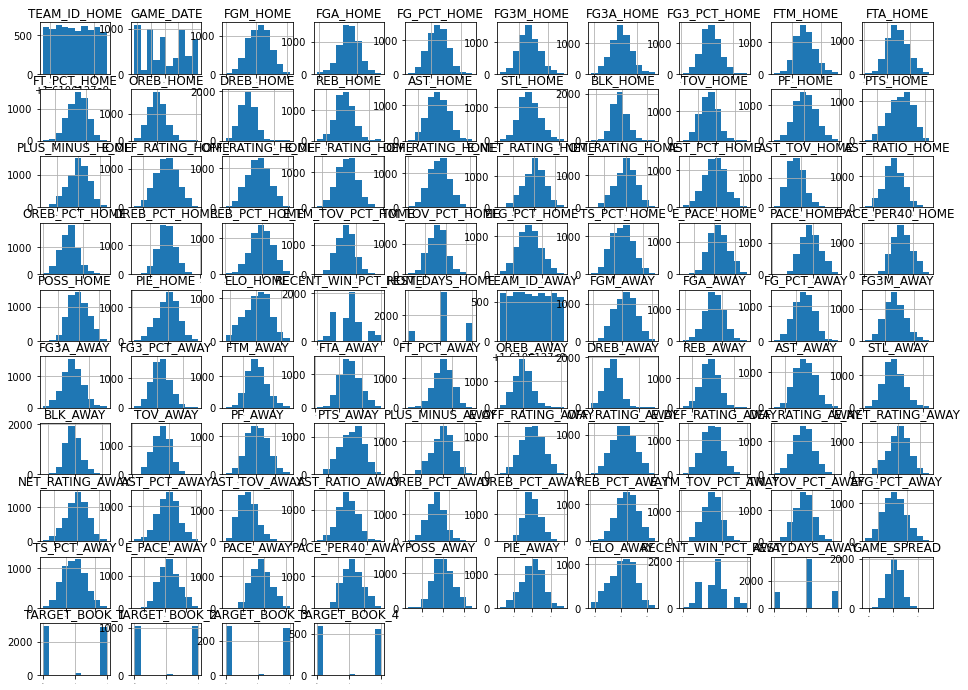

In [42]:
#check distribution of data
final_df.hist(figsize=(16,12), xlabelsize=0)

In [44]:
check_missing_vals(final_df)

['SPREAD_2_AWAY',
 'SPREAD_3_AWAY',
 'SPREAD_4_AWAY',
 'SPREAD_2_HOME',
 'SPREAD_3_HOME',
 'SPREAD_4_HOME',
 'TARGET_BOOK_2',
 'TARGET_BOOK_3',
 'TARGET_BOOK_4']

In [45]:
final_df.to_csv('data_book_1.csv')
print('Data converted to csv')
print('Runtime : ', datetime.now() - start_time)

Data converted to csv
Runtime :  1:04:59.854660


TO DO:
- Remove unnecessary columns (including GAME_SREAD and book cols)
- Standardize data
- PCA